In [99]:
import numpy as np
import pandas as pd
from numpy import mgrid
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils import shuffle


In [100]:
def generate_guassian_dataset(mus, covs, N):
    dataset = []
    for i in range(3):
        pure_data = np.random.randn(N, 2)
        cov_array = np.array(covs[i])
        upper_cov_matrix = np.linalg.cholesky(cov_array)
        guassian_x = pure_data @ upper_cov_matrix + mus[i]
        data = np.c_[guassian_x, np.zeros(guassian_x.shape[0], dtype=np.int64)+i]
        data[:, 2] = data[:, 2].astype(np.int64)
        dataset.append(data)
    dataset = np.concatenate(dataset)
    return dataset
   

dataset1 = generate_guassian_dataset([[3,6], [5, 4], [6, 6]], [[[1.5, 0],[0, 1.5]], [[2, 0],[0, 2]], [[1, 0],[0, 1]]], 500)
np.savetxt("dataset1.csv", dataset1, delimiter=",")

dataset2 = generate_guassian_dataset([[3,6], [5, 4], [6, 6]], [[[1.5, 0.1],[0.1, 0.5]], [[1, -0.2],[-0.2, 2]], [[2, -0.25],[-0.25, 1.5]]], 500)
np.savetxt("dataset2.csv", dataset2, delimiter=",")
dataset2


array([[4.66035687, 6.69653483, 0.        ],
       [3.37882673, 6.28186777, 0.        ],
       [3.61393253, 7.87680962, 0.        ],
       ...,
       [4.99680281, 6.06080282, 2.        ],
       [6.82651343, 6.42146071, 2.        ],
       [5.32289025, 4.87713871, 2.        ]])

In [101]:
dataset_1 = pd.read_csv('dataset1.csv', header=None)
dataset_2 = pd.read_csv('dataset22.csv', header=None)
dataset_1 = shuffle(dataset_1)
dataset_2 = shuffle(dataset_2)

dataset_1_train, dataset_1_test = dataset_1[:int(0.8*len(dataset_1))], dataset_1[int(0.8*len(dataset_1)):]
dataset_2_train, dataset_2_test = dataset_2[:int(0.8*len(dataset_2))], dataset_2[int(0.8*len(dataset_2)):]
dataset_2_train

,0,1,2
1057,4.570191,7.107293,2.0
94,3.146292,6.649442,0.0
346,3.325213,6.812791,0.0
130,3.761611,6.463739,0.0
583,6.067519,1.978970,1.0
...,...,...,...
473,3.001040,6.369037,0.0
506,4.654346,4.791331,1.0
1339,6.956976,5.240040,2.0
1255,6.106615,4.981061,2.0


In [102]:
class BeyesianClassifier:
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame):
        self.X_train = train_data[train_data.columns[0:2]].to_numpy()
        self.y_train = train_data[train_data.columns[2:3]].to_numpy().reshape(self.X_train.shape[0],)
        self.X_test = test_data[test_data.columns[0:2]].to_numpy()
        self.y_test = test_data[test_data.columns[2:3]].to_numpy().reshape(self.X_test.shape[0],)
        self.y_test = self.y_test.astype(int)
        self.y_train = self.y_train.astype(int)
        self.number_of_class = 3
        self.m, self.n = self.X_train.shape
        self.phis = []
        self.mus = []
        self.sigmas = []
    def find_parameters(self):
        classes_sum = np.bincount(self.y_train)
        self.phis = classes_sum/self.m
        for i in range(self.number_of_class):
            x_avg = self.X_train[self.y_train==i].mean(0)
            self.mus.append(x_avg)
        for i in range(self.number_of_class):
            x_class = self.X_train[self.y_train==i] - self.mus[i]
            cov = x_class.T @ x_class / x_class.shape[0]
            self.sigmas.append(cov)
    def predict(self, input):
        class_likelihood = []
        for i in range (self.number_of_class):
            X = input - self.mus[i]
            mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
            likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
            posteriori = likelihood * self.phis[i]
            class_likelihood.append(posteriori)
        return np.stack(class_likelihood)

    def accuracy_precisions_recalls_f1(self):
        print("Test Data:")
        y_hat_test = self.predict(self.X_test).argmax(0)
        one_hot_y_hat_test = np.zeros((y_hat_test.size, y_hat_test.max() + 1))
        one_hot_y_hat_test[np.arange(y_hat_test.size), y_hat_test] = 1
        y_true_test = self.y_test
        one_hot_y_true_test = np.zeros((y_true_test.size, y_true_test.max() + 1))
        one_hot_y_true_test[np.arange(y_true_test.size), y_true_test] = 1
        test_confusion_matrix = one_hot_y_hat_test.T @ one_hot_y_true_test
        print("Confusion Matrix: \n", test_confusion_matrix)
        print("Accuracy: {} %".format((np.diag(test_confusion_matrix).sum()/test_confusion_matrix.sum())*100))
        print("Precision: {} %".format(test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0]*100))
        print("Recall: {} %".format(test_confusion_matrix[0, 0]/test_confusion_matrix.sum(0)[0]*100))
        print("F1: {}".format(2*((test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0])*(test_confusion_matrix[1, 1]
                                /test_confusion_matrix.sum(0)[0]))/((test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0])
                                +(test_confusion_matrix[1, 1] /test_confusion_matrix.sum(0)[0]))))
        print("Train Data:")
        y_hat_train = self.predict(self.X_train).argmax(0)
        one_hot_y_hat_train = np.zeros((y_hat_train.size, y_hat_train.max() + 1))
        one_hot_y_hat_train[np.arange(y_hat_train.size), y_hat_train] = 1
        y_true_train = self.y_train
        one_hot_y_true_train = np.zeros((y_true_train.size, y_true_train.max() + 1))
        one_hot_y_true_train[np.arange(y_true_train.size), y_true_train] = 1
        train_confusion_matrix = one_hot_y_hat_train.T @ one_hot_y_true_train
        print("Confusion Matrix: \n", train_confusion_matrix)
        print("Accuracy: {} %".format((np.diag(train_confusion_matrix).sum()/train_confusion_matrix.sum())*100))
        print("Precision: {} %".format(train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0]*100))
        print("Recall: {} %".format(train_confusion_matrix[0, 0]/train_confusion_matrix.sum(0)[0]*100))
        print("F1: {}".format(2*((train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0])*(train_confusion_matrix[0, 0]
                                /train_confusion_matrix.sum(0)[0]))/((train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0])
                                +(train_confusion_matrix[0, 0] /train_confusion_matrix.sum(0)[0]))))

    def draw_decision_boundary2(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(15,10)
        ax.set_aspect("equal")
        y_hat_train = self.predict(self.X_train).argmax(0)
        index = np.where(y_hat_train != self.y_train)
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.1, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.1]

        x_1 = np.stack([x,y], -1).reshape(-1, 2)
        a = self.predict(x_1)
        f = a[1] - a[0]
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        f = a[2] - a[1]
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        f = a[2] - a[0]
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        train_colors=['red' if l==0 else 'blue' if l==1 else 'yellow' for l in self.y_train[:]]
        test_colors=['red' if l==0 else 'blue' if l==1 else 'yellow' for l in self.y_test[:]]
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1],marker=".", color=train_colors)
        plt.scatter(self.X_train[index, 0], self.X_train[index, 1], marker="s", facecolor="none", edgecolor='black')
        plt.scatter(self.X_test[:, 0], self.X_test[:, 1],marker="+", color=test_colors)
        # pltylim(np.min(self.X_train[:, 1],np.max(self.X_train[:, 1])))
        plt.show()
    
    def plot_pdf(self):
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.1, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.1]
        xy = np.column_stack([x.flat, y.flat])
        i = 0
        X = xy - self.mus[i]
        mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
        likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
        prob1 = likelihood
        prob1 = prob1.reshape(x.shape)
        
        i = 1
        X = xy - self.mus[i]
        mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
        likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
        prob2 = likelihood
        prob2 = prob2.reshape(x.shape)

        i = 2
        X = xy - self.mus[i]
        mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
        likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
        prob3 = likelihood
        prob3 = prob3.reshape(x.shape)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x,y,np.maximum(np.maximum(prob1,prob2),prob3), cmap=cm.coolwarm)
        plt.show()
        
    def plot_contour(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(20,10)
        ax.set_aspect("equal")
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.1, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.1]
        x_1 = np.stack([x,y], -1).reshape(-1, 2)
        out = self.predict(x_1)
        f = out[0]
        f = f.reshape(x.shape)
        plt.contour(x, y, f)
        f = out[1]
        f = f.reshape(x.shape)
        plt.contour(x, y, f)
        f = out[2]
        f = f.reshape(x.shape)
        plt.contour(x, y, f)
        f = out[0] - np.maximum(out[1], out[2])
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        f = out[1] - np.maximum(out[0], out[2])
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        f = out[2] - np.maximum(out[0], out[1])
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        plt.show()

Test Data:
Confusion Matrix: 
 [[83. 12.  2.]
 [12. 68.  8.]
 [ 5. 20. 90.]]
Accuracy: 80.33333333333333 %
Precision: 85.56701030927834 %
Recall: 83.0 %
F1: 0.7577873254564984
Train Data:
Confusion Matrix: 
 [[324.  59.  21.]
 [ 43. 268.  38.]
 [ 33.  73. 341.]]
Accuracy: 77.75 %
Precision: 80.19801980198021 %
Recall: 81.0 %
F1: 0.8059701492537314


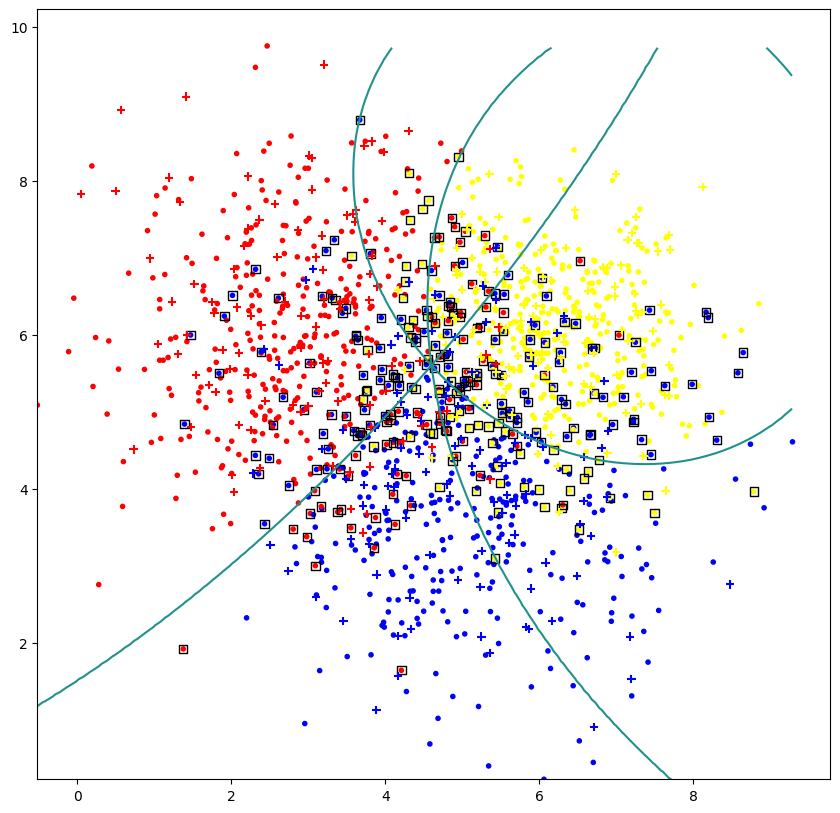

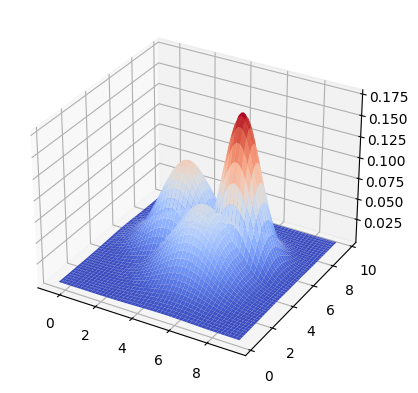

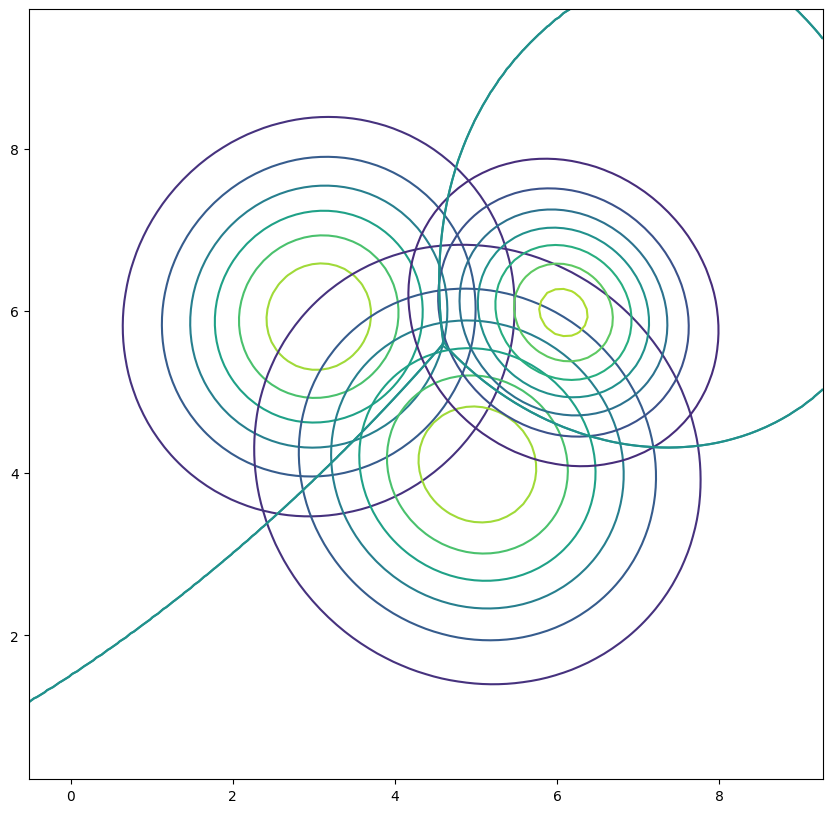

In [103]:
first_classifier = BeyesianClassifier(dataset_1_train, dataset_1_test)
first_classifier.find_parameters()
first_classifier.accuracy_precisions_recalls_f1()
first_classifier.draw_decision_boundary2()
first_classifier.plot_pdf()
first_classifier.plot_contour()

Test Data:
Confusion Matrix: 
 [[86. 14. 14.]
 [ 7. 81. 10.]
 [10. 12. 66.]]
Accuracy: 77.66666666666666 %
Precision: 75.43859649122807 %
Recall: 83.49514563106796 %
F1: 0.7700641167366792
Train Data:
Confusion Matrix: 
 [[341.  40.  56.]
 [ 22. 302.  52.]
 [ 34.  51. 302.]]
Accuracy: 78.75 %
Precision: 78.03203661327231 %
Recall: 85.8942065491184 %
F1: 0.8177458033573142


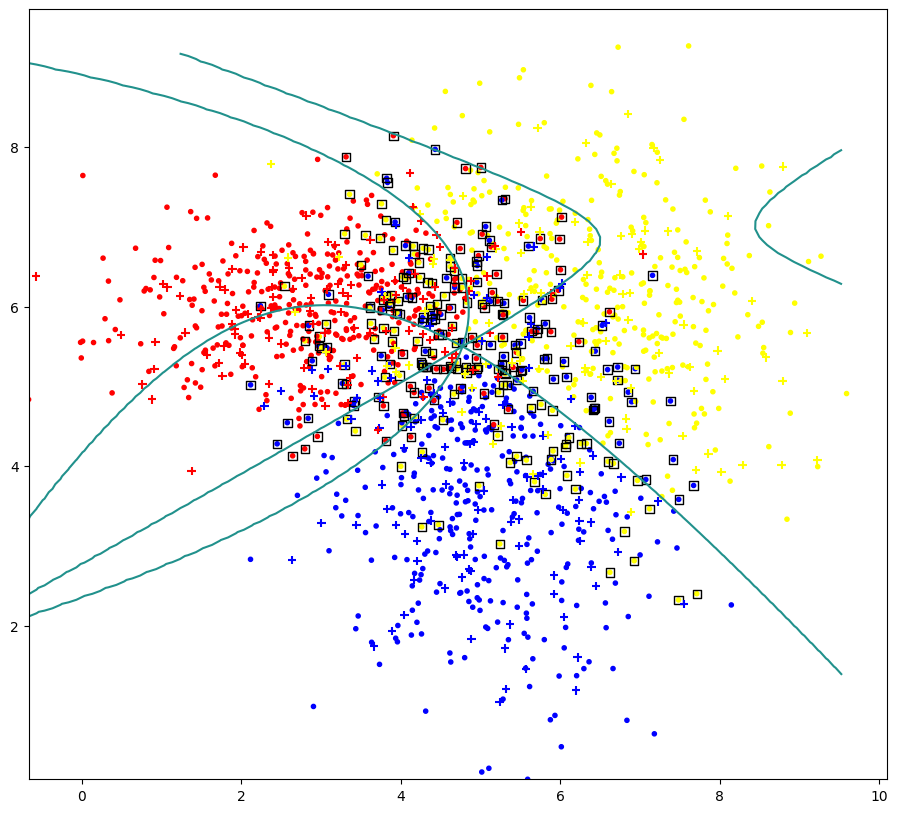

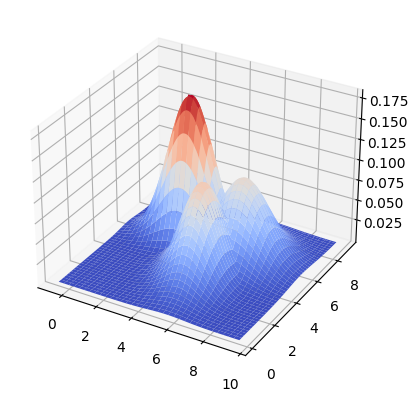

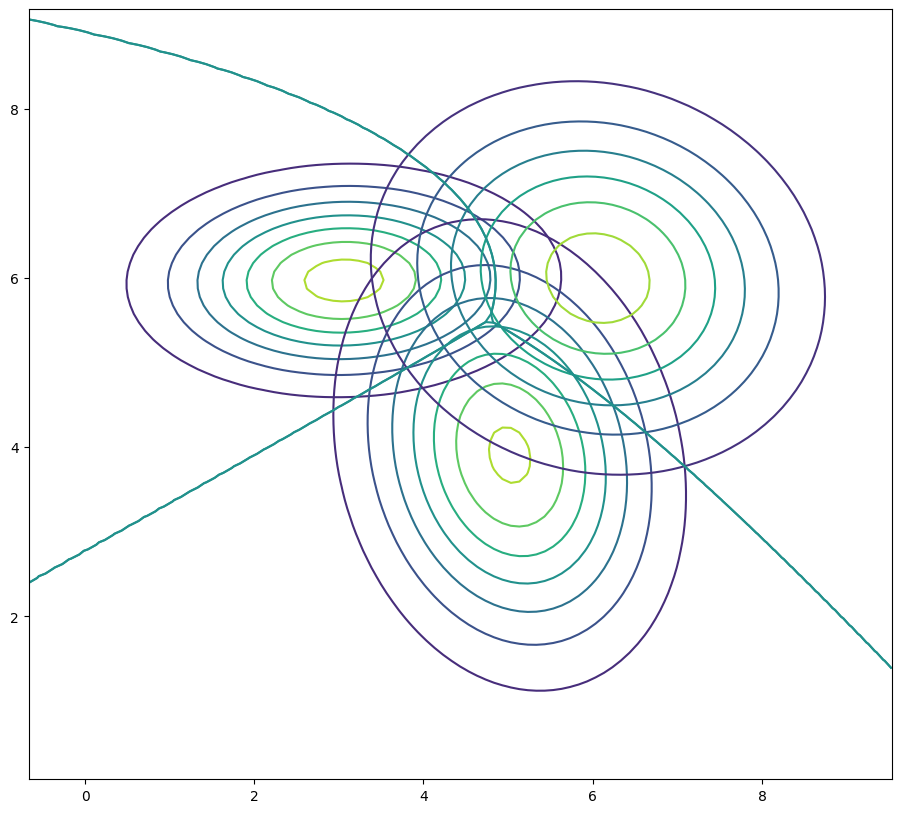

In [104]:
second_classifier = BeyesianClassifier(dataset_2_train, dataset_2_test)
second_classifier.find_parameters()
second_classifier.accuracy_precisions_recalls_f1()
second_classifier.draw_decision_boundary2()
second_classifier.plot_pdf()
second_classifier.plot_contour()